In [4]:
%load_ext autoreload
%autoreload 2

## Import Modules

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
pwd

'/home/biagio/code/BiaPri/my_projects/Challenges_Projects/Capco/Churn_Modelling/notebook'

In [7]:
path = '/home/biagio/code/BiaPri/my_projects/Challenges_Projects/Capco/Churn_Modelling/data/Churn_Modeling.csv'

In [8]:
csv_path = os.path.join('..','data')
csv_path

'../data'

In [9]:
df = pd.read_csv(os.path.join(csv_path,'Churn_Modeling.csv')).drop(columns=['RowNumber','Surname'])
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
df.dtypes

CustomerId           int64
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [11]:
df['CustomerId']=pd.to_numeric(df['CustomerId'])
df.dtypes

CustomerId           int64
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

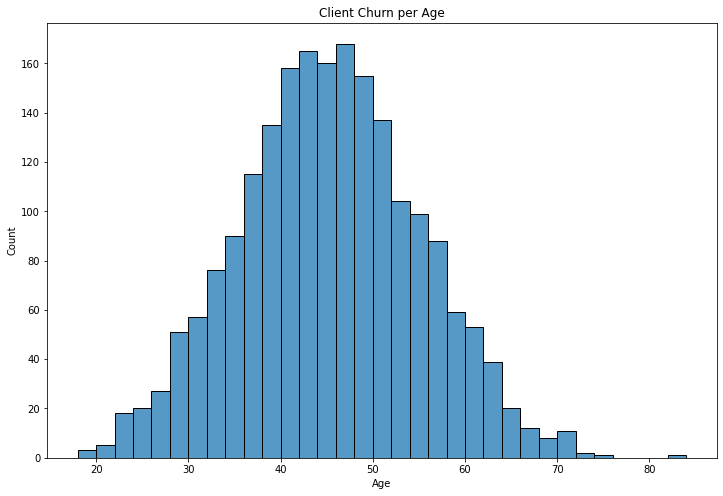

In [12]:
exited = df[df['Exited']==1]

plt.figure(figsize=(12,8))
plt.title('Client Churn per Age')
sns.histplot(x='Age', data=exited)

plt.show()

## __Data Processing__

### __Creating Age Bins__

In [13]:
def age_transformer(X):
    # 18-30
    if X>18 and X<=30:
        return '18-30'
    
    # 30-40
    elif X>30 and X<=40:
        return '30-40'
    
    # 40-50
    elif X>40 and X<=50:
        return '40-50'
    
    # 50-65
    elif X>50 and X<=60:
        return '50-65'
        
    else:
        return '65>'
    
df['Age'] = df['Age'].apply(age_transformer)

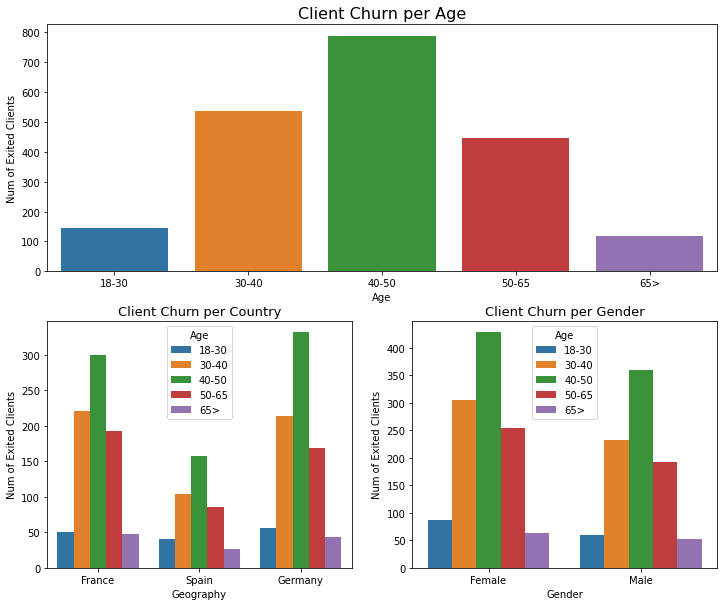

In [14]:
exited = df[df['Exited']==1]

fig = plt.figure(figsize=(12,10))
spec2 = GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0:])
ax2 = fig.add_subplot(spec2[1, 0])
ax3 = fig.add_subplot(spec2[1, 1])


ax1.set_title('Client Churn per Age', size=16)
sns.countplot(x='Age', order=['18-30','30-40','40-50','50-65','65>'], data=exited, ax=ax1)
ax1.set_ylabel('Num of Exited Clients')

ax2.set_title('Client Churn per Country', size=13)
sns.countplot(x='Geography', hue='Age', hue_order=['18-30','30-40','40-50','50-65','65>'], data=exited, ax=ax2)
ax2.set_ylabel('Num of Exited Clients')

ax3.set_title('Client Churn per Gender', size=13)
sns.countplot(x='Gender', hue='Age', hue_order=['18-30','30-40','40-50','50-65','65>'], data=exited, ax=ax3)
ax3.set_ylabel('Num of Exited Clients')


plt.show()

### __Category Age__

In [15]:
ohe = OneHotEncoder(sparse=False)
df[['18-30','30-40','40-50','50-65','65>']]  = ohe.fit_transform(df[['Age']])
df.drop(columns='Age', inplace=True)

### __Category Geo__

In [16]:
ohe = OneHotEncoder(sparse=False)
df[['France','Germany','Spain']]  = ohe.fit_transform(df[['Geography']])
df.drop(columns='Geography', inplace=True)

### __Category Gender__

In [17]:
ohe = OneHotEncoder(sparse=False)
df[['Female','Male']]  = ohe.fit_transform(df[['Gender']])
df.drop(columns='Gender', inplace=True)

### Category CustomerId = Time related!

In [22]:
lower = np.mean(df['CustomerId'])+1.5*np.std(df['CustomerId'])

def id_transformer(X, lower):

    # Old
    if X<lower:
        return 'Old Client'
    
    # New
    else:
        return 'New Client'

df['CustomerId'] = df['CustomerId'].apply(lambda x: id_transformer(x, lower))

In [23]:
ohe = OneHotEncoder(sparse=False)
df[['New Client', 'Old Client']]  = ohe.fit_transform(df[['CustomerId']])
df.drop(columns='CustomerId', inplace=True)

In [24]:
df.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,18-30,30-40,40-50,50-65,65>,France,Germany,Spain,Female,Male,New Client,Old Client
0,619,2,0.00,1,1,1,101348.88,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,608,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,502,8,159660.80,3,1,0,113931.57,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,699,1,0.00,2,0,0,93826.63,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,850,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


### Churn Linear Correlations

In [25]:
def custom_palette(x, y, color):
    palette = {}
    lower = np.mean(x)-np.std(x)
    upper = np.mean(x)+np.std(x)

    for val,name in zip(x,y):
        if val < lower:
            palette[name] = color[0]
        elif upper > val > lower:
            palette[name] = color[1]
        else:
            palette[name] = color[2]
    return palette

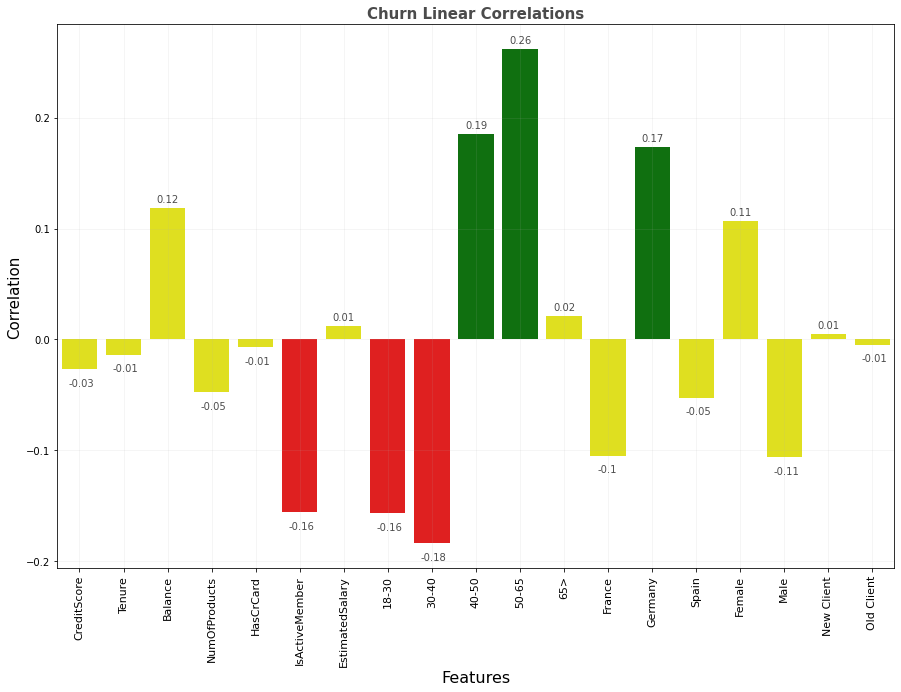

In [26]:
res = df.corr()['Exited'].drop('Exited')
feat = list(res.keys())
corr = res.values

plt.figure(figsize=(15,10))
plt.title('Churn Linear Correlations', size=15, fontweight="bold", alpha=0.7)

palette = custom_palette(corr, feat, color=['red','yellow','green'])
ax = sns.barplot(x=feat, y=corr, palette=palette)

for i, v in enumerate(corr):
    if v > 0:
        ax.text(i-0.25, v+0.005, str(round(v,2)), color='black', alpha=0.7)
    else:
        ax.text(i-0.25, v-0.015, str(round(v,2)), color='black', alpha=0.7)
        
plt.xlabel('Features', size=16)
plt.ylabel('Correlation', size=15)
plt.xticks(rotation=90, size=11)
plt.grid(alpha=0.15)
plt.show()

In [27]:
# low_corr = res[(res<0.005)].keys()
# df.drop(columns = low_corr, inplace=True) #Correlation less/equal than 0.005

## Baseline Score

In [28]:
y_pred = np.zeros((len(df),))
y_true = df['Exited']

baseline = accuracy_score(y_true, y_pred)
print(f'Baseline Score: {baseline*100} %')

Baseline Score: 79.63 %


In [29]:
X = df.drop(columns='Exited')
y = df['Exited']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
rs = RobustScaler().fit(X_train)
X_train = rs.transform(X_train)
X_test = rs.transform(X_test) 

## Simple Logistic

In [32]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr.predict(X_test)
print(f'Score: {accuracy_score(y_test, y_pred)*100} %')

### GridSearch (No real change)

In [ ]:
param_grid = {'C':[0.1,0.5,1,5,10],
              'solver':['newton-cg', 'lbfgs']}
grid = GridSearchCV(LogisticRegression(max_iter=100), param_grid, scoring='accuracy', cv=5)
res = grid.fit(X_train, y_train)

In [ ]:
best = res.best_estimator_
best

In [ ]:
y_pred = best.predict(X_test)
print(f'Score: {accuracy_score(y_test, y_pred)*100} %')

## SVM

In [1072]:
svm = SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1073]:
y_pred = svm.predict(X_test)
print(f'Score: {accuracy_score(y_test, y_pred)*100} %')

Score: 86.0 %


### GridSearch 

In [1074]:
param_grid = {'C':[0.1, 0.5, 1, 5],
              'kernel':['poly', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5)
res = grid.fit(X_train, y_train)

best = res.best_estimator_
best

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1075]:
y_pred = best.predict(X_test)
print(f'Score: {round(accuracy_score(y_test, y_pred)*100,2)} %')

Score: 86.47 %


## AdaBoost

In [988]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), learning_rate=0.5)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [989]:
y_pred = ada.predict(X_test)
print(f'Score: {round(accuracy_score(y_test, y_pred)*100)} %')

Score: 86 %


In [1085]:
param_grid = {'learning_rate': np.arange(0.01, 1, 0.05),
              'algorithm': ['SAMME.R']}
grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=150), param_grid, scoring='accuracy', cv=5)
res = grid.fit(X_train, y_train)

best = res.best_estimator_
best

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [1086]:
y_pred = best.predict(X_test)
print(f'Score: {round(accuracy_score(y_test, y_pred)*100,2)} %')

Score: 86.5 %


## XGBoost

In [39]:
import xgboost as xgb
xg_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain', interaction_constraints='',
                              learning_rate=0.3, max_delta_step=0, max_depth=6,
                              min_child_weight=1,
                              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1, verbosity=None)

xg_clf.fit(X_train, y_train)

[21:43:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [40]:
y_pred = xg_clf.predict(X_test)
print(f'Score: {accuracy_score(y_test, y_pred)*100} %')

Score: 85.43333333333332 %


In [47]:
param_grid = {
    "max_depth": [2, 3, 4, 5],
    "learning_rate": [0.1, 0.01, 0.05],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="accuracy")

# Fit
res = grid_cv.fit(X_train, y_train)
best = res.best_estimator_
best

/home/biagio/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:07:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [48]:
y_pred = best.predict(X_test)
print(f'Score: {round(accuracy_score(y_test, y_pred)*100,2)} %')

Score: 86.83 %


/home/biagio/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## NN?